In [1]:
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud

In [2]:
# Load the data
comments = pd.read_csv("comments.csv")
efftreat = pd.read_csv("efftreat.csv")
apen = pd.read_csv("apen.csv")

# Join comments to scores.
efftreat = pd.merge(comments, efftreat, how="left", on="id")
apen = pd.merge(comments, apen, how="left", on="id")

Now we can clean the two datasets:
- Use .info() to inspect for NAs and check the column types are appropriate
- Drop records with no comment or score
- Create a binary score column (since we're creating a binary classifier).
- Remove hashtags, mentions and urls
- Convert all text to lower case and remove punctuation and stop words
- Apply lemmatization to reduce the number of words our model needs to consider.

In [5]:
efftreat.info()
apen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        10000 non-null  int64  
 1   comment   9357 non-null   object 
 2   efftreat  9900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 312.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       10000 non-null  int64  
 1   comment  9357 non-null   object 
 2   apen     9949 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 312.5+ KB


In [3]:
# Drop records with no comment or score.
efftreat = efftreat.dropna(subset=["comment", "efftreat"])
apen = apen.dropna(subset=["comment", "apen"])

# Simplify our scores into binary values.
efftreat["score"] = np.where(efftreat["efftreat"] > 0, 1, 0)
apen["score"] = np.where(apen["apen"] > 0, 1, 0)


# Remove # hashtags, @ mentions and urls, then clean up whitespace left behind.
def remove_tags(col):
    # Remove hashtags.
    col = re.sub(r"#\w+", "", col)
    # Remove mentions.
    col = re.sub(r"@\w+", "", col)
    # Remove URLs.
    col = col.replace(" / ", "/")
    col = re.sub(r"https:[^\s]+", "", col)
    # Clean up multiple whitespaces.
    col = re.sub(r"\s+", " ", col)
    return col.strip()


efftreat["comment"] = efftreat["comment"].apply(remove_tags)
apen["comment"] = apen["comment"].apply(remove_tags)

# Convert comment text to lower case.
efftreat["comment"] = efftreat["comment"].str.lower()
apen["comment"] = apen["comment"].str.lower()

# Remove punctuation
efftreat["comment"] = efftreat["comment"].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
apen["comment"] = apen["comment"].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


# Remove stop words.
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)


stop_words = set(stopwords.words("english"))
efftreat["comment"] = efftreat["comment"].apply(remove_stopwords)
apen["comment"] = apen["comment"].apply(remove_stopwords)

# Apply lemmatization to simplify text further.
lemmatizer = WordNetLemmatizer()
efftreat["comment"] = efftreat["comment"].apply(lambda x: lemmatizer.lemmatize(x))
apen["comment"] = apen["comment"].apply(lambda x: lemmatizer.lemmatize(x))

Now our data is clean and we can build our model. We will in fact build two neural networks, each performing a binary relevancy classification for one of the two topics (Effective Treatment and Attention to Physical & Environmental Needs).

We functionize the process of tokenizing the comments and creating train, validation and test datasets so we can conveniently repeat the process for our two datasets.

In [4]:
# Tokenize text and pad to uniform length, then split into train/val/test sets.
def test_val_train(df, tokenizer):
    tokenizer.fit_on_texts(df["comment"])
    tokens = tokenizer.texts_to_sequences(df["comment"])
    input = pad_sequences(tokens, padding="post")
    X_train, X_test, y_train, y_test = train_test_split(input, df["score"], test_size=0.3, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

    # Get necessary model params as well
    input_dim = len(tokenizer.word_index)+1
    input_length = input.shape[1]
    return X_train, X_val, X_test, y_train, y_val, y_test, input_dim, input_length

tokenizer = Tokenizer()
X_train_efft, X_val_efft, X_test_efft, y_train_efft, y_val_efft, y_test_efft, efft_dim, efft_length = test_val_train(efftreat, tokenizer)
X_train_apen, X_val_apen, X_test_apen, y_train_apen, y_val_apen, y_test_apen, apen_dim, apen_length = test_val_train(apen, tokenizer)

### Effective Treatment Model
We build and train a neural network using the keras sequential API. 

For this short exercise, we will use relatively simple tried-and-tested choices. We use an Embedding input layer followed by a GlobalAveragePoolingLayer to try and preserve relationships between words while overcoming complexity stemming from the high dimensionality of the input. Then, we have a 64-node layer with a rectified linear unit (relu) activation function, and a single output neuron with a sigmoid activation function to give us an output on [0,1] which can easily be converted to a binary classification. We use a binary cross entropy loss function since we have a binary classification problem.

In practice, we would want to tune model parameters based on validation performance, e.g. the width and depth of the network, the activation functions, the number of epochs, or the choice of optimizer. For example, we plot the training and validation loss curves, which could be used to inform our choice of the number of epochs. In this model, we see that the training loss continues to decrease but the validation loss plateaus, suggesting that increasing the number of epochs will simply lead to overfitting and degraded performance on unseen data.


In [10]:
# Build and compile the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=efft_dim, output_dim=128, input_length=efft_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
history_efft = model.fit(X_train_efft, y_train_efft, epochs=10, validation_data=(X_val_efft, y_val_efft))

Epoch 1/10
203/203 [==============================] - 4s 15ms/step - loss: 0.6343 - accuracy: 0.6755 - val_loss: 0.6264 - val_accuracy: 0.6763
Epoch 2/10
203/203 [==============================] - 3s 15ms/step - loss: 0.6131 - accuracy: 0.6776 - val_loss: 0.5891 - val_accuracy: 0.6763
Epoch 3/10
203/203 [==============================] - 3s 15ms/step - loss: 0.5359 - accuracy: 0.7079 - val_loss: 0.4960 - val_accuracy: 0.7813
Epoch 4/10
203/203 [==============================] - 3s 14ms/step - loss: 0.4558 - accuracy: 0.7986 - val_loss: 0.4677 - val_accuracy: 0.7799
Epoch 5/10
203/203 [==============================] - 3s 15ms/step - loss: 0.4163 - accuracy: 0.8180 - val_loss: 0.4253 - val_accuracy: 0.8187
Epoch 6/10
203/203 [==============================] - 3s 15ms/step - loss: 0.3864 - accuracy: 0.8322 - val_loss: 0.4232 - val_accuracy: 0.8007
Epoch 7/10
203/203 [==============================] - 3s 15ms/step - loss: 0.3624 - accuracy: 0.8441 - val_loss: 0.4185 - val_accuracy: 0.8115

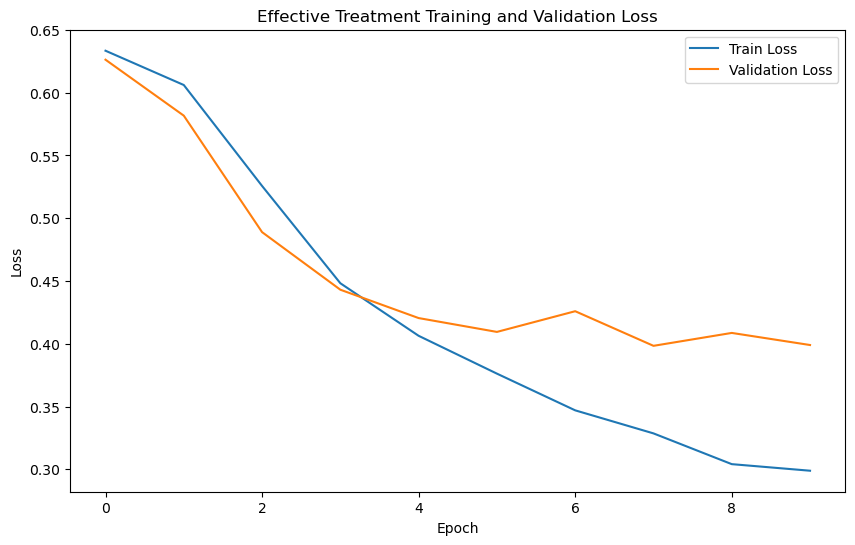

In [6]:
# Plot training and validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history_efft.history['loss'], label='Train Loss')
plt.plot(history_efft.history['val_loss'], label='Validation Loss')
plt.title('Effective Treatment Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Predict on the test set
y_pred_efft = model.predict(X_test_efft)
y_pred_class_efft = np.where(y_pred_efft < 0.5, 0, 1)

# Print classification report including F1-score to give us more insight into classifications that just accuracy.
print(classification_report(y_test_efft, y_pred_class_efft))

44/44 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       445
           1       0.89      0.89      0.89       944

    accuracy                           0.85      1389
   macro avg       0.83      0.83      0.83      1389
weighted avg       0.85      0.85      0.85      1389



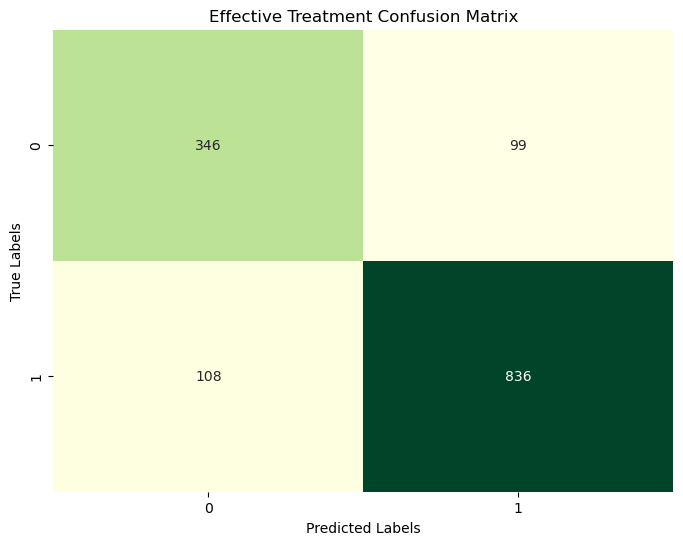

In [12]:
# Plot the confusion matrix
conf_matrix_efft = confusion_matrix(y_test_efft, y_pred_class_efft)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_efft, annot=True, fmt='d', cmap='YlGn', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Effective Treatment Confusion Matrix')
plt.show()

We see that we have an average F1 score of 0.85. The model performs more strongly on the relevant class (class 1), which is as expected considering there are roughly twice as many examples in the training data. However, the model is still relatively accurate (F1 score 0.76) on the class 0 samples. This may be improved by model tuning, or addressing the class imbalance using methods such as oversampling to artificially balance the dataset, or class weighting to increase the impact of mistakes on the class 0 samples during training.

## Attention to Physical & Environmental Needs Model
We repeat the modelling process above for the apen dataset, reusing the same model architecture. In practice, we would want to tune parameters separately for the two models.

In [41]:
# Build and compile the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=apen_dim, output_dim=128, input_length=apen_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
history_apen = model.fit(X_train_apen, y_train_apen, epochs=10, validation_data=(X_val_apen, y_val_apen))

Epoch 1/10
204/204 [==============================] - 4s 16ms/step - loss: 0.5276 - accuracy: 0.7862 - val_loss: 0.5019 - val_accuracy: 0.7960
Epoch 2/10
204/204 [==============================] - 3s 14ms/step - loss: 0.5051 - accuracy: 0.7893 - val_loss: 0.4924 - val_accuracy: 0.7960
Epoch 3/10
204/204 [==============================] - 3s 15ms/step - loss: 0.4902 - accuracy: 0.7920 - val_loss: 0.4830 - val_accuracy: 0.7996
Epoch 4/10
204/204 [==============================] - 3s 15ms/step - loss: 0.4542 - accuracy: 0.8034 - val_loss: 0.4472 - val_accuracy: 0.8082
Epoch 5/10
204/204 [==============================] - 3s 16ms/step - loss: 0.4047 - accuracy: 0.8253 - val_loss: 0.4186 - val_accuracy: 0.8203
Epoch 6/10
204/204 [==============================] - 3s 16ms/step - loss: 0.3580 - accuracy: 0.8460 - val_loss: 0.4013 - val_accuracy: 0.8332
Epoch 7/10
204/204 [==============================] - 3s 15ms/step - loss: 0.3013 - accuracy: 0.8700 - val_loss: 0.4081 - val_accuracy: 0.8339

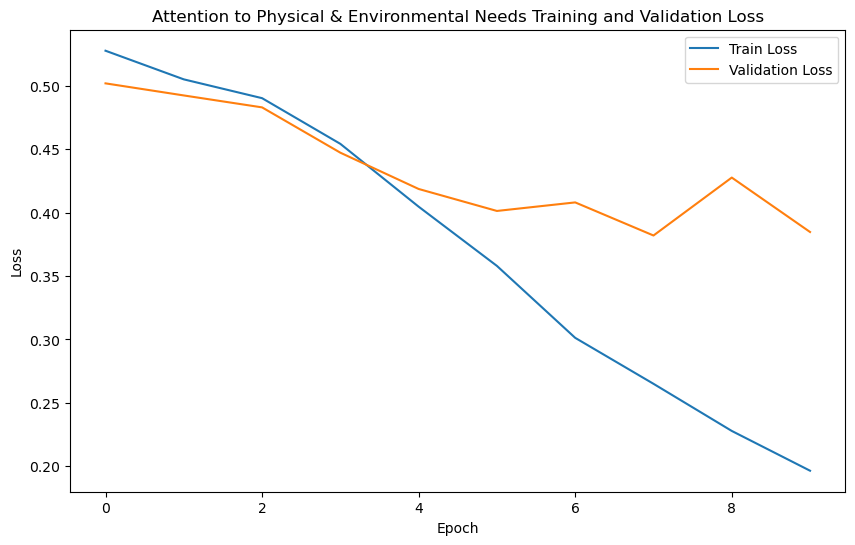

In [42]:
# Plot training and validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history_apen.history['loss'], label='Train Loss')
plt.plot(history_apen.history['val_loss'], label='Validation Loss')
plt.title('Attention to Physical & Environmental Needs Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Predict on the test set
y_pred_apen = model.predict(X_test_apen)
y_pred_class_apen = np.where(y_pred_apen < 0.5, 0, 1)

# Print classification report.
print(classification_report(y_test_apen, y_pred_class_apen))

44/44 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.90      0.95      0.93      1129
           1       0.74      0.56      0.64       267

    accuracy                           0.88      1396
   macro avg       0.82      0.76      0.78      1396
weighted avg       0.87      0.88      0.87      1396



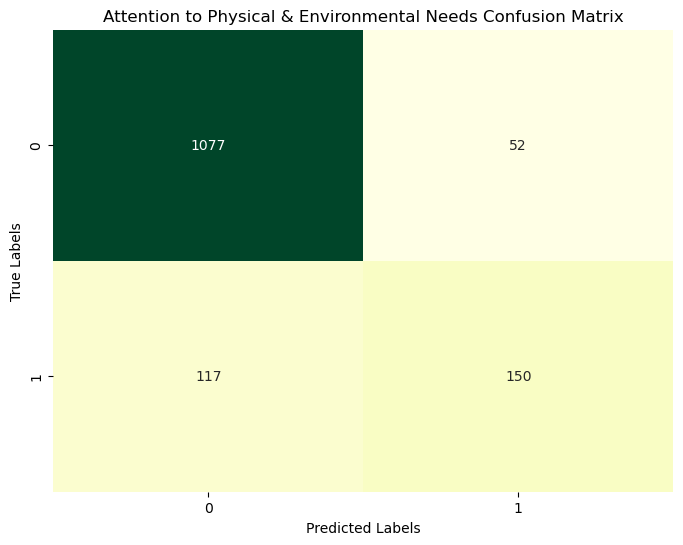

In [14]:
# Plot the confusion matrix
conf_matrix_apen = confusion_matrix(y_test_apen, y_pred_class_apen)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_apen, annot=True, fmt='d', cmap='YlGn', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Attention to Physical & Environmental Needs Confusion Matrix')
plt.show()

This model shows similar overall performance to the Effective Treatment model, with an average F1 score of 0.88. However, this is heavily weighted towards strong performance in the class 0 (irrelevant) records, with substantially poorer performance (F1 score 0.64) in the relevant class 1 records. This is likely driven primarily by the significant class imbalance which could be addressed by oversampling or class weighting as discussed previously.

## Theme Visualisations
To try and get some intuitive insight into key themes as well as the classification models, we take a look at the most common words in each set of relevant comments, and pick out the words that are unique to one dataset. In doing so, we may be able to identify the driving themes in each topic, and filter out universally common phrases such as "hospital" that don't tell us much.

There are more advanced theme analysis methods may give more robust insight for practical use, such as considering n-grams rather than individual words to give better context, or using a different method entirely such as Latent Dirichlet Allocation which would allow us to identify groups of words that indicate important themes.

In [22]:
# Filter out irrelevant comments
efft_comments = ' '.join(efftreat.loc[efftreat["score"] == 1, "comment"])
apen_comments = ' '.join(apen.loc[apen["score"] == 1, "comment"])

# Get word counts
efft_counts = Counter(efft_comments.split())
apen_counts = Counter(apen_comments.split())

# Identify most common words
efft_common = efft_counts.most_common(50)
apen_common = apen_counts.most_common(50)

# Get words from each that don't appear in the other dataset.
efft_distinct = [(word, count) for word, count in efft_common if word not in [w for w, c in apen_common]]
apen_distinct = [(word, count) for word, count in apen_common if word not in [w for w, c in efft_common]]

print("Top words unique to Effective Treatment comments:")
for word, count in efft_distinct:
    print(f"{word}: {count}")
    
print("\nWords unique to Attention to Physical & Environmental Needs comments:")
for word, count in apen_distinct:
    print(f"{word}: {count}")    

Top words unique to Effective Treatment comments:
today: 640
doctor: 639
thanks: 620
nhs: 601
appointment: 593
dont: 562
helpful: 546
went: 535
back: 533
seen: 531

Words unique to Attention to Physical & Environmental Needs comments:
patients: 239
covid: 229
parking: 225
felt: 221
clean: 217
pain: 215
also: 209
safe: 208
even: 205
unit: 201


As expected, the Effective Treatment comments focus on the staff and the appointments, highlighting successful outcomes ("thanks", "helpful") and potentially unsuccessful outcomes as well ("dont", "went", "back", with the latter two having similar frequencies meaning that it may be appropriate to consider them as a bigram which suggests that follow up appointments were needed due to cancellation or unsuccessful treatment).

The APEN comments focus on environmental topics such such as hygiene ("covid", "clean"), practicality ("parking"), and atmosphere ("safe"), as well as patients' experiences ("pain", "felt").


We can also create word clouds for these lists if we wish to visualise them.

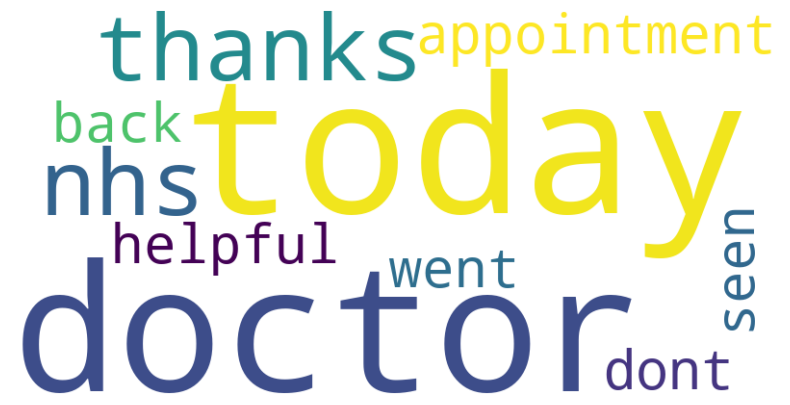

In [25]:
efft_comments = ' '.join([word for word, _ in efft_distinct])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(efft_comments)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

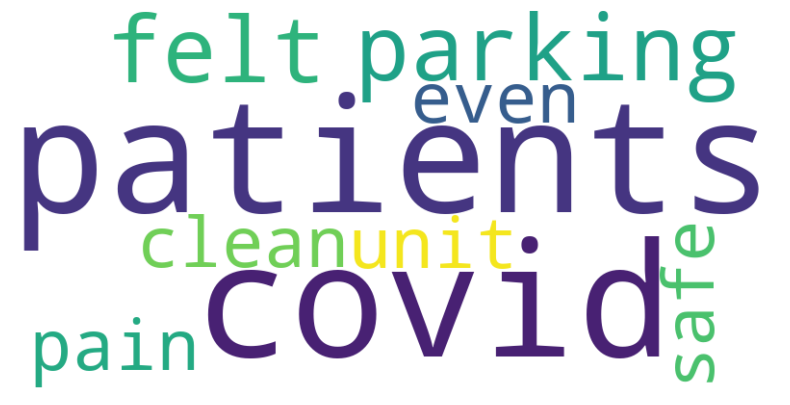

In [27]:
apen_comments = ' '.join([word for word, _ in apen_distinct])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(apen_comments)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()